2023-11-21 06:35:55.585198: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


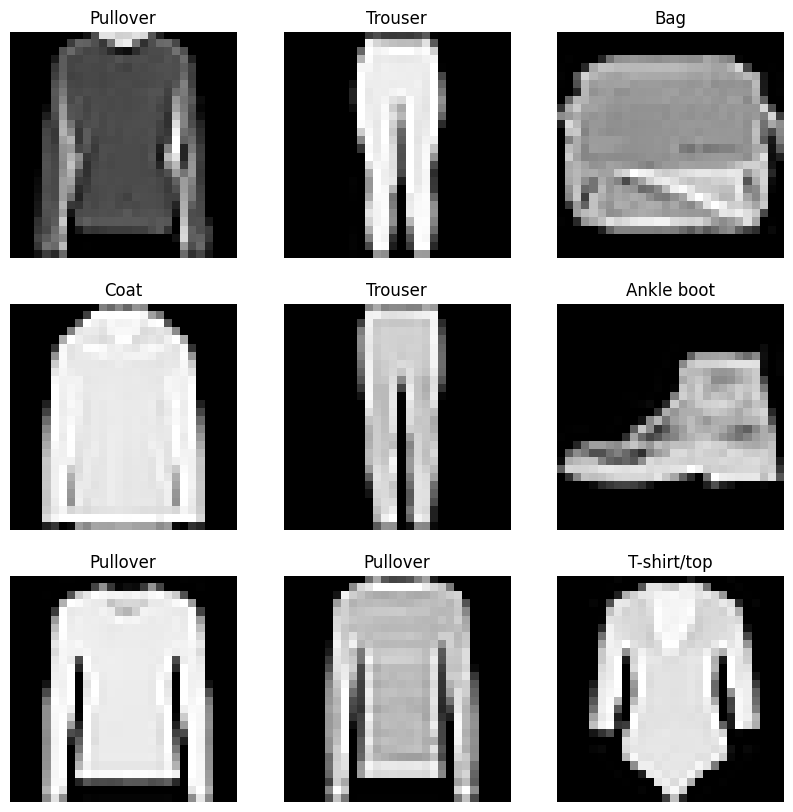

In [43]:
# Import the necessary modules
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds

# Define the hyperparameters
batch_size = 128
num_epochs = 30

# Load the Fashion MNIST dataset
transform = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
trainset = tfds.load('fashion_mnist', split='train', as_supervised=True).map(lambda x, y: (transform(x), y)).batch(batch_size)
testset = tfds.load('fashion_mnist', split='test', as_supervised=True).map(lambda x, y: (transform(x), y)).batch(batch_size)
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

# preview the dataset
for image, label in trainset.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i], cmap='gray')
        plt.title(classes[label[i]])
        plt.axis('off')
# save the figure
plt.savefig('demo-MNIST.png')

In [2]:
# summary the size of the dataset
print(trainset.cardinality().numpy()*batch_size)
print(testset.cardinality().numpy()*batch_size)
# the dimension of the dataset
print(image.shape)

60032
10112
(128, 28, 28, 1)


In [3]:
# Define the teacher model (a small convolutional neural network)
class Teacher(tf.keras.Model):
    def __init__(self):
        super(Teacher, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')
        self.pool1 = tf.keras.layers.MaxPool2D(2, 2)
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(64, activation='relu')
        self.fc2 = tf.keras.layers.Dense(64, activation='relu')
        self.fc3 = tf.keras.layers.Dense(64, activation='relu')
        self.fc4 = tf.keras.layers.Dense(10)

    def call(self, x):
        x = self.pool1(self.conv1(x))
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

# Define another teacher model (a small deep neural network)
class Teacher_DNN(tf.keras.Model):
    def __init__(self):
        super(Teacher_DNN, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(64, activation='relu')
        self.fc2 = tf.keras.layers.Dense(64, activation='relu')
        self.fc3 = tf.keras.layers.Dense(64, activation='relu')
        self.fc4 = tf.keras.layers.Dense(10)

    def call(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

# Define the student model (a smaller fully-connected neural network)
class Simple(tf.keras.Model):
    def __init__(self):
        super(Simple, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(8000, activation = 'relu')
        # add dropout layer: 
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.fc2 = tf.keras.layers.Dense(10)


    def call(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        # add dropout layer
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class Student_Mimic(tf.keras.Model):
    def __init__(self):
        super(Student_Mimic, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        # bottleneck layer
        self.fc1 = tf.keras.layers.Dense(20, activation='linear')
        self.fc2 = tf.keras.layers.Dense(8000, activation = 'relu')
        self.fc3 = tf.keras.layers.Dense(10)

    def call(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


Epoch 1/30
469/469 [==============================] - 17s 33ms/step - loss: 0.7276 - accuracy: 0.7432 - val_loss: 0.4770 - val_accuracy: 0.8245
Epoch 2/30
469/469 [==============================] - 14s 30ms/step - loss: 0.4140 - accuracy: 0.8491 - val_loss: 0.3937 - val_accuracy: 0.8579
Epoch 3/30
469/469 [==============================] - 14s 30ms/step - loss: 0.3526 - accuracy: 0.8710 - val_loss: 0.3480 - val_accuracy: 0.8785
Epoch 4/30
469/469 [==============================] - 12s 26ms/step - loss: 0.3167 - accuracy: 0.8835 - val_loss: 0.3274 - val_accuracy: 0.8845
Epoch 5/30
469/469 [==============================] - 14s 31ms/step - loss: 0.2904 - accuracy: 0.8939 - val_loss: 0.3095 - val_accuracy: 0.8897
Epoch 6/30
469/469 [==============================] - 19s 41ms/step - loss: 0.2694 - accuracy: 0.9014 - val_loss: 0.2967 - val_accuracy: 0.8941
Epoch 7/30
469/469 [==============================] - 44s 95ms/step - loss: 0.2518 - accuracy: 0.9082 - val_loss: 0.2852 - val_accuracy:

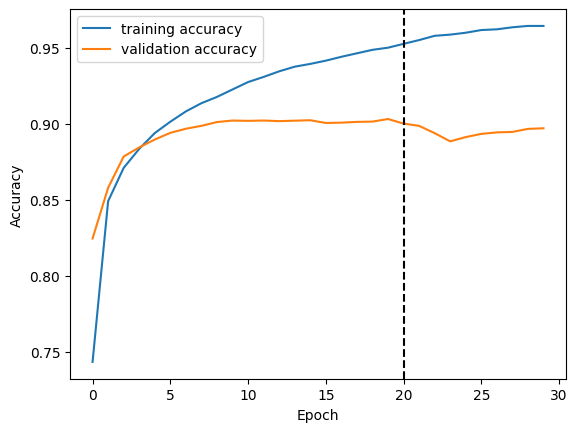

The best epoch is 20
79/79 [==============================] - 1s 15ms/step - loss: 0.3989 - accuracy: 0.8971
Accuracy of the teacher model on the test set: 89.71 %


<Figure size 640x480 with 0 Axes>

In [19]:
num_epochs = 30
# Instantiate the models
teacher_cnn = Teacher()

# train the teacher CNN model
# Define the loss function and the optimizer
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# Train the teacher model on the original hard targets
teacher_cnn.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])
teacher_cnn.fit(trainset, epochs=num_epochs, validation_data=testset)
print('Finished training the teacher model')

# visualize the training process
plt.plot(teacher_cnn.history.history['accuracy'], label='training accuracy')
plt.plot(teacher_cnn.history.history['val_accuracy'], label='validation accuracy')
# add one vertical line to indicate the best epoch
plt.axvline(x=teacher_cnn.history.history['val_accuracy'].index(max(teacher_cnn.history.history['val_accuracy'])), color='red', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.show()
# save the figure
plt.savefig('teacher_cnn.png')

# take the epoch with highest validation accuracy as the final model
best_epoch = teacher_cnn.history.history['val_accuracy'].index(max(teacher_cnn.history.history['val_accuracy'])) + 1
print('The best epoch is %d' % best_epoch)
# store the best model
if num_epochs == best_epoch:
    teacher_cnn.save('teacher_cnn', save_format='tf', overwrite=True, include_optimizer=True)

# Evaluate the teacher model on the test set
teacher_cnn.evaluate(testset)
print('Accuracy of the teacher model on the test set: %.2f %%' % (teacher_cnn.metrics[-1].result() * 100))

Epoch 1/50
469/469 [==============================] - 5s 7ms/step - loss: 0.6988 - accuracy: 0.7552 - val_loss: 0.4988 - val_accuracy: 0.8200
Epoch 2/50
 32/469 [=>............................] - ETA: 3s - loss: 0.4543 - accuracy: 0.8408

469/469 [==============================] - 4s 8ms/step - loss: 0.4482 - accuracy: 0.8418 - val_loss: 0.4441 - val_accuracy: 0.8407
Epoch 3/50
469/469 [==============================] - 3s 5ms/step - loss: 0.4012 - accuracy: 0.8565 - val_loss: 0.4111 - val_accuracy: 0.8536
Epoch 4/50
469/469 [==============================] - 3s 7ms/step - loss: 0.3735 - accuracy: 0.8650 - val_loss: 0.4038 - val_accuracy: 0.8584
Epoch 5/50
469/469 [==============================] - 3s 7ms/step - loss: 0.3542 - accuracy: 0.8707 - val_loss: 0.3898 - val_accuracy: 0.8641
Epoch 6/50
469/469 [==============================] - 4s 8ms/step - loss: 0.3386 - accuracy: 0.8758 - val_loss: 0.3783 - val_accuracy: 0.8671
Epoch 7/50
469/469 [==============================] - 4s 8ms/step - loss: 0.3260 - accuracy: 0.8809 - val_loss: 0.3791 - val_accuracy: 0.8691
Epoch 8/50
469/469 [==============================] - 3s 6ms/step - loss: 0.3149 - accuracy: 0.8848 - val_loss: 0.3736 - val_accuracy: 0.8702
Epoch 9/50
469/46

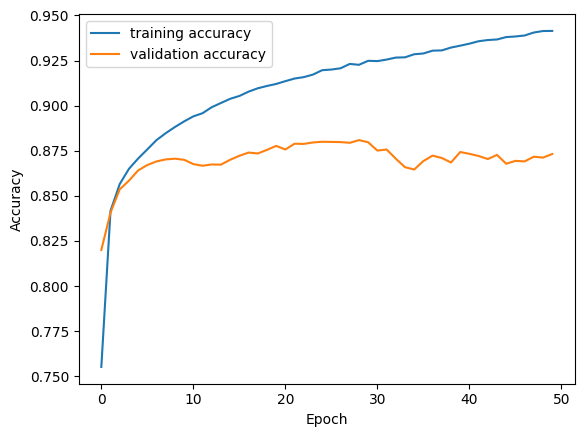

79/79 [==============================] - 0s 5ms/step - loss: 0.4419 - accuracy: 0.8732
Accuracy of the teacher model on the test set: 87.32 %


<Figure size 640x480 with 0 Axes>

In [5]:
num_epochs = 50
# Instantiate the model
teacher_dnn = Teacher_DNN()

# train the teacher DNN model
# Define the loss function and the optimizer
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# Train the teacher model on the original hard targets
teacher_dnn.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])
teacher_dnn.fit(trainset, epochs=num_epochs, validation_data=testset)
print('Finished training the teacher model')

# visualize the training process
plt.plot(teacher_dnn.history.history['accuracy'], label='training accuracy')
plt.plot(teacher_dnn.history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# save the figure
plt.savefig('teacher_dnn.png')

# Evaluate the teacher model on the test set
teacher_dnn.evaluate(testset)
print('Accuracy of the teacher model on the test set: %.2f %%' % (teacher_dnn.metrics[-1].result() * 100))

In [6]:
# load the teacher model
teacher_cnn = tf.keras.models.load_model('teacher_cnn')

teacher_cnn.summary()

Model: "teacher_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           multiple                  160       
                                                                 
 max_pooling2d_3 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         multiple                  0         
                                                                 
 dense_26 (Dense)            multiple                  200768    
                                                                 
 dense_27 (Dense)            multiple                  4160      
                                                                 
 dense_28 (Dense)            multiple                  4160      
                                                         

79/79 [==============================] - 1s 15ms/step - loss: 0.3214 - accuracy: 0.8870
Finished training the simple student model


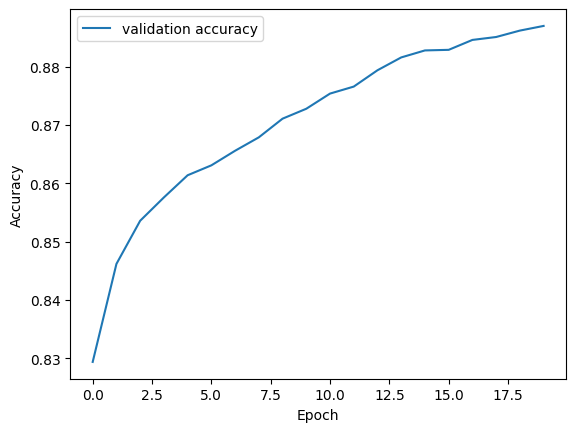

79/79 [==============================] - 1s 14ms/step - loss: 0.3214 - accuracy: 0.8870
Accuracy of the simple student model on the test set: 88.70 %


<Figure size 640x480 with 0 Axes>

In [7]:
num_epochs = 20
# Instantiate the student model
simple_net = Simple()
# Train the student model on the original hard targets
# Define the loss function and the optimizer
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# initialize the epoch and accuracy in a dictionary
results = {'epoch': [], 'snn_accuracy': [], 'snn_L2_accuracy': [], 'snn_KL_accuracy': [],
                 'snn_mimic_KL_accuracy': [], 'snn_mimic_L2_accuracy': []
                 }

# Train the student model on the original hard targets from the teacher model
simple_net.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainset):
        with tf.GradientTape() as tape:
            outputs = simple_net(inputs)
            # Compute the hard loss
            loss = criterion(labels, outputs)
        # Apply the gradients
        grads = tape.gradient(loss, simple_net.trainable_variables)
        optimizer.apply_gradients(zip(grads, simple_net.trainable_variables))
        running_loss += loss.numpy()
    # Evaluate the simple student model on the test set
    simple_net.evaluate(testset)
    # store the accuracy and epoch
    results['epoch'].append(epoch)
    results['snn_accuracy'].append(simple_net.metrics[-1].result().numpy())

print('Finished training the simple student model')

# visualize the training process
plt.plot(results['epoch'], results['snn_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# save the figure
plt.savefig('simple_net.png')

# Evaluate the simple student model on the test set
simple_net.evaluate(testset)
print('Accuracy of the simple student model on the test set: %.2f %%' % (simple_net.metrics[-1].result() * 100))

79/79 [==============================] - 2s 26ms/step - loss: 0.4806 - accuracy: 0.8429
Finished training the simple student model


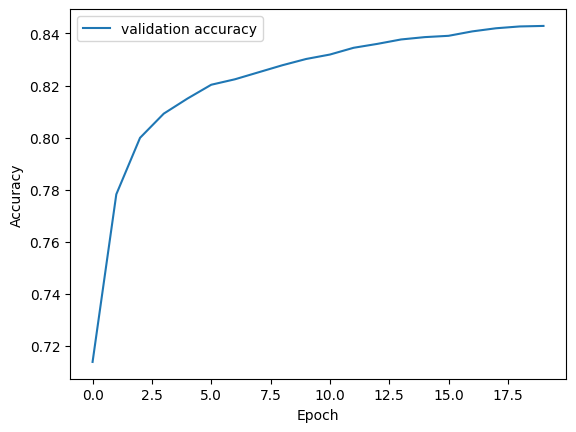

79/79 [==============================] - 3s 31ms/step - loss: 0.3214 - accuracy: 0.8870
Accuracy of the simple student model on the test set: 84.29 %


<Figure size 640x480 with 0 Axes>

In [8]:
# Instantiate the student model
simple_net_L2 = Simple()

temperature = 1
# Train the student model on the original hard targets
# Define the loss function and the optimizer
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# Train the student model on the original hard targets from the teacher model
simple_net_L2.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainset):
        with tf.GradientTape() as tape:
            outputs = simple_net_L2(inputs)
            with tf.GradientTape(watch_accessed_variables=False) as tape2:
                tape2.watch(outputs)
                teacher_outputs = teacher_cnn(inputs)
            # Compute the L2 loss
            loss = tf.reduce_mean(tf.keras.losses.MSE(tf.nn.softmax(teacher_outputs / temperature), tf.nn.softmax(outputs / temperature)))
        # Apply the gradients
        grads = tape.gradient(loss, simple_net_L2.trainable_variables)
        optimizer.apply_gradients(zip(grads, simple_net_L2.trainable_variables))
        running_loss += loss.numpy()
    # Evaluate the simple student model on the test set
    simple_net_L2.evaluate(testset)
    # store the accuracy and epoch
    # results['epoch'].append(epoch)
    results['snn_L2_accuracy'].append(simple_net_L2.metrics[-1].result().numpy())

print('Finished training the simple student model')

# visualize the training process
plt.plot(results['epoch'], results['snn_L2_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# save the figure
plt.savefig('simple_net_L2.png')

# Evaluate the simple student model on the test set
simple_net.evaluate(testset)
print('Accuracy of the simple student model on the test set: %.2f %%' % (simple_net_L2.metrics[-1].result() * 100))

79/79 [==============================] - 1s 18ms/step - loss: 0.3336 - accuracy: 0.8804
Finished training the simple student model


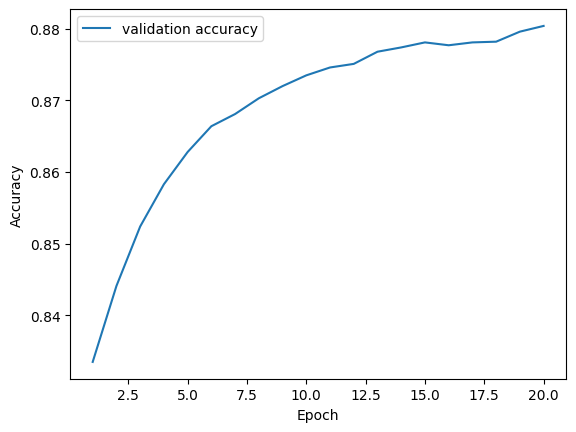

79/79 [==============================] - 1s 16ms/step - loss: 0.3336 - accuracy: 0.8804
Accuracy of the simple student model on the test set: 88.04 %


<Figure size 640x480 with 0 Axes>

In [16]:
# Instantiate the student model
simple_net_KL = Simple()

temperature = 1
# Train the student model on the original hard targets
# Define the loss function and the optimizer
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# Train the student model on the original hard targets from the teacher model
simple_net_KL.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainset):
        with tf.GradientTape() as tape:
            outputs = simple_net_KL(inputs)
            with tf.GradientTape(watch_accessed_variables=False) as tape2:
                tape2.watch(outputs)
                teacher_outputs = teacher_cnn(inputs)
            # Compute the KL loss
            loss = tf.reduce_mean(tf.keras.losses.KLDivergence()(tf.nn.softmax(teacher_outputs / temperature), tf.nn.softmax(outputs / temperature)))
        # Apply the gradients
        grads = tape.gradient(loss, simple_net_KL.trainable_variables)
        optimizer.apply_gradients(zip(grads, simple_net_KL.trainable_variables))
        running_loss += loss.numpy()
    # Evaluate the simple student model on the test set
    simple_net_KL.evaluate(testset)
    # store the accuracy and epoch
    # results['epoch'].append(epoch)
    results['snn_KL_accuracy'].append(simple_net_KL.metrics[-1].result().numpy())

print('Finished training the simple student model')

# visualize the training process
plt.plot(results['epoch'], results['snn_KL_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# save the figure
plt.savefig('simple_net_KL.png')

# Evaluate the simple student model on the test set
simple_net_KL.evaluate(testset)
print('Accuracy of the simple student model on the test set: %.2f %%' % (simple_net_KL.metrics[-1].result() * 100))

79/79 [==============================] - 0s 6ms/step - loss: 0.3665 - accuracy: 0.8709
Finished training the student model


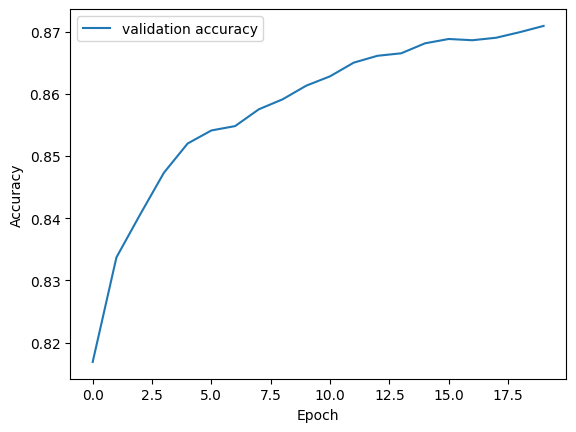

79/79 [==============================] - 0s 6ms/step - loss: 0.3665 - accuracy: 0.8709
Accuracy of the student model on the test set: 87.09 %


<Figure size 640x480 with 0 Axes>

In [9]:
# Instantiate the model
student_mimic_KL = Student_Mimic()

alpha = 0.9
temperature = 1

# Train the student model on the combined soft and hard targets
# Define the loss function and the optimizer
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# Get the full list of trainable variables
trainable_variables = student_mimic_KL.trainable_variables

# Build the optimizer with the full list of trainable variables
optimizer.build(trainable_variables)

# Define the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# Train the student model on the soft targets from the teacher model
student_mimic_KL.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainset):
        with tf.GradientTape() as tape:
            outputs = student_mimic_KL(inputs)
            with tf.GradientTape(watch_accessed_variables=False) as tape2:
                tape2.watch(outputs)
                teacher_outputs = teacher_cnn(inputs)
            # Compute the soft loss and the hard loss
            KL_loss = tf.keras.losses.KLDivergence()(tf.nn.softmax(teacher_outputs / temperature), tf.nn.softmax(outputs / temperature))
            # hard_loss = criterion(labels, outputs)
            # L2_loss = tf.keras.losses.MSE(teacher_outputs, outputs)
            # Combine the soft loss and the hard loss with a weighting factor
            # loss = alpha * soft_loss + (1 - alpha) * hard_loss
            loss = KL_loss
        # Apply the gradients
        grads = tape.gradient(loss, student_mimic_KL.trainable_variables)
        optimizer.apply_gradients(zip(grads, student_mimic_KL.trainable_variables))
        running_loss += loss.numpy()
    # Evaluate the student model on the test set
    student_mimic_KL.evaluate(testset)
    # store the accuracy and epoch
    # result_mimic_KL['epoch'].append(epoch)
    results['snn_mimic_KL_accuracy'].append(student_mimic_KL.metrics[-1].result().numpy())

print('Finished training the student model')

# visualize the training process
plt.plot(results['epoch'], results['snn_mimic_KL_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# save the figure
plt.savefig('student_mimic_KL.png')


# Evaluate the student model on the test set
student_mimic_KL.evaluate(testset)
print('Accuracy of the student model on the test set: %.2f %%' % (student_mimic_KL.metrics[-1].result() * 100))


79/79 [==============================] - 0s 5ms/step - loss: 0.5227 - accuracy: 0.8262
Finished training the student model


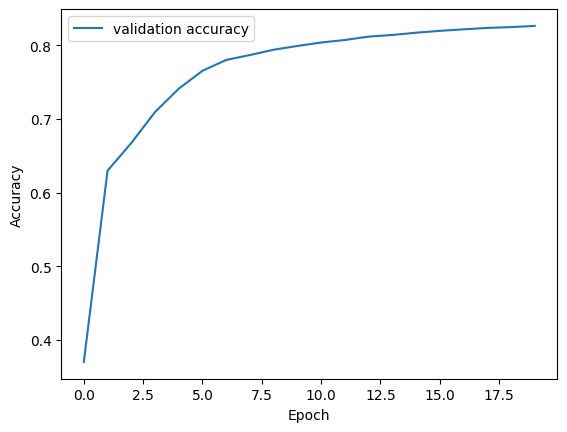

79/79 [==============================] - 0s 5ms/step - loss: 0.5227 - accuracy: 0.8262
Accuracy of the student model on the test set: 82.62 %


<Figure size 640x480 with 0 Axes>

In [10]:
# Instantiate the model
student_mimic_L2 = Student_Mimic()

temperature = 1

# Train the student model on the combined soft and hard targets
# Define the loss function and the optimizer
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# Get the full list of trainable variables
trainable_variables = student_mimic_L2.trainable_variables

# Build the optimizer with the full list of trainable variables
optimizer.build(trainable_variables)

# Define the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# Train the student model on the soft targets from the teacher model
student_mimic_L2.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainset):
        with tf.GradientTape() as tape:
            outputs = student_mimic_L2(inputs)
            with tf.GradientTape(watch_accessed_variables=False) as tape2:
                tape2.watch(outputs)
                teacher_outputs = teacher_cnn(inputs)
            # Compute the soft loss and the hard loss
            # KL_loss = tf.keras.losses.KLDivergence()(tf.nn.softmax(teacher_outputs / temperature), tf.nn.softmax(outputs / temperature))
            L2_loss = tf.reduce_mean(tf.keras.losses.MSE(tf.nn.softmax(teacher_outputs / temperature), tf.nn.softmax(outputs / temperature)))
            loss = L2_loss
        # Apply the gradients
        grads = tape.gradient(loss, student_mimic_L2.trainable_variables)
        optimizer.apply_gradients(zip(grads, student_mimic_L2.trainable_variables))
        running_loss += loss.numpy()
    # Evaluate the student model on the test set
    student_mimic_L2.evaluate(testset)
    # store the accuracy and epoch
    # results['epoch'].append(epoch)
    results['snn_mimic_L2_accuracy'].append(student_mimic_L2.metrics[-1].result().numpy())

print('Finished training the student model')

# visualize the training process
plt.plot(results['epoch'], results['snn_mimic_L2_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# save the figure
plt.savefig('student_mimic_L2_loss.png')


# Evaluate the student model on the test set
student_mimic_L2.evaluate(testset)
print('Accuracy of the student model on the test set: %.2f %%' % (student_mimic_L2.metrics[-1].result() * 100))


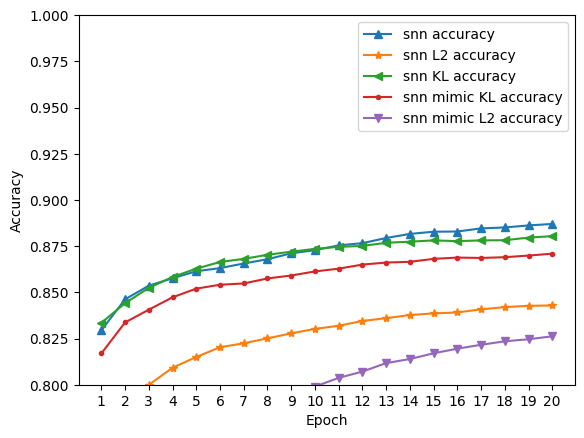

In [41]:
# results['epoch'] = [i+1 for i in range(num_epochs)]

# plot the training process of these models and add the points with different shapes
plt.plot(results['epoch'], results['snn_accuracy'], label='snn accuracy', marker='^')
plt.plot(results['epoch'], results['snn_L2_accuracy'], label='snn L2 accuracy', marker='*')
plt.plot(results['epoch'], results['snn_KL_accuracy'], label='snn KL accuracy', marker='<')
plt.plot(results['epoch'], results['snn_mimic_KL_accuracy'], label='snn mimic KL accuracy', marker='.')
plt.plot(results['epoch'], results['snn_mimic_L2_accuracy'], label='snn mimic L2 accuracy', marker='v')

# set the x axis value
plt.xticks(results['epoch'])
# set y axis range
plt.ylim(0.8, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.show()
# save the figure
plt.savefig('student_mimic.png')

In [20]:
# save the results in a csv file
import pandas as pd
df = pd.DataFrame(results)
df.to_csv('results.csv', index=False)

In [36]:
class Student_Mimic_20k(tf.keras.Model):
    def __init__(self):
        super(Student_Mimic_20k, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        # bottleneck layer
        self.fc1 = tf.keras.layers.Dense(20, activation='linear')
        self.fc2 = tf.keras.layers.Dense(20000, activation = 'relu')
        self.fc3 = tf.keras.layers.Dense(10)

    def call(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
class Student_Mimic_4h(tf.keras.Model):
    def __init__(self):
        super(Student_Mimic_4h, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        # bottleneck layer
        self.fc1 = tf.keras.layers.Dense(20, activation='linear')
        self.fc2 = tf.keras.layers.Dense(400, activation = 'relu')
        self.fc3 = tf.keras.layers.Dense(10)

    def call(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

## Compare the accurarcy of student models with respect to accuracy of teacher models

In [38]:
num_epochs_teacher = 8
num_epochs_student = 15

temperature = 1

# Instantiate the teacher model
teacher_cnn = Teacher()

# reset the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# initialize the teacher accuracy and student accuracy in a dictionary
results2 = {'teacher epoch': [], 't_cnn_accuracy': [], 'snn_mimic_4h_accuracy': [], 'snn_mimic_8k_accuracy': [], 'snn_mimic_20k_accuracy': []}

# train the teacher CNN model
teacher_cnn.compile(optimizer=optimizer, loss=criterion, metrics=['accuracy'])

for i in range(num_epochs_teacher):
    for j, (inputs, labels) in enumerate(trainset):
        # train teacher first
        with tf.GradientTape() as tape:
            outputs = teacher_cnn(inputs)
            loss = criterion(labels, outputs)
        # Apply the gradients
        grads = tape.gradient(loss, teacher_cnn.trainable_variables)
        optimizer.apply_gradients(zip(grads, teacher_cnn.trainable_variables))
    # Evaluate the teacher model on the test set
    teacher_cnn.evaluate(testset)
    # store the accuracy and epoch
    results2['teacher epoch'].append(i)
    results2['t_cnn_accuracy'].append(teacher_cnn.metrics[-1].result().numpy())

    print('Finished training the teacher model in epoch ', i)

    # instantiate the student model
    student_mimic_20k = Student_Mimic_20k()
    student_mimic_8k = Student_Mimic()
    student_mimic_4h = Student_Mimic_4h()

    # reset the optimizer
    optimizer_mimic_20k = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    optimizer_mimic_8k = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    optimizer_mimic_4h = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    
    # Train the student model on the soft targets with KL loss
    student_mimic_20k.compile(optimizer=optimizer_mimic_20k, loss=criterion, metrics=['accuracy'])

    for epoch in range(num_epochs_student):
        for k, (inputs_20k, labels_20k) in enumerate(trainset):
            with tf.GradientTape() as tape:
                outputs_20k = student_mimic_20k(inputs_20k)
                with tf.GradientTape(watch_accessed_variables=False) as tape2:
                    tape2.watch(outputs_20k)
                    teacher_outputs = teacher_cnn(inputs_20k)
                # Compute the soft loss
                loss = tf.keras.losses.KLDivergence()(tf.nn.softmax(teacher_outputs / temperature), tf.nn.softmax(outputs_20k / temperature))
            # Apply the gradients
            grads = tape.gradient(loss, student_mimic_20k.trainable_variables)
            optimizer_mimic_20k.apply_gradients(zip(grads, student_mimic_20k.trainable_variables))
        # Evaluate the student model on the test set
        student_mimic_20k.evaluate(testset)
    # store the final accuracy
    results2['snn_mimic_20k_accuracy'].append(student_mimic_20k.metrics[-1].result().numpy())

    # Train the student model on the soft targets with KL loss
    student_mimic_8k.compile(optimizer=optimizer_mimic_8k, loss=criterion, metrics=['accuracy'])

    for epoch in range(num_epochs_student):
        for k, (inputs_8k, labels_8k) in enumerate(trainset):
            with tf.GradientTape() as tape:
                outputs_8k = student_mimic_8k(inputs_8k)
                with tf.GradientTape(watch_accessed_variables=False) as tape2:
                    tape2.watch(outputs_8k)
                    teacher_outputs = teacher_cnn(inputs_8k)
                # Compute the soft loss
                loss = tf.keras.losses.KLDivergence()(tf.nn.softmax(teacher_outputs / temperature), tf.nn.softmax(outputs_8k / temperature))
            # Apply the gradients
            grads = tape.gradient(loss, student_mimic_8k.trainable_variables)
            optimizer_mimic_8k.apply_gradients(zip(grads, student_mimic_8k.trainable_variables))
        # Evaluate the student model on the test set
        student_mimic_8k.evaluate(testset)
    # store the final accuracy
    results2['snn_mimic_8k_accuracy'].append(student_mimic_8k.metrics[-1].result().numpy())

    # Train the student model on the soft targets with KL loss
    student_mimic_4h.compile(optimizer=optimizer_mimic_4h, loss=criterion, metrics=['accuracy'])

    for epoch in range(num_epochs_student):
        for k, (inputs_4h, labels_4h) in enumerate(trainset):
            with tf.GradientTape() as tape:
                outputs_4h = student_mimic_4h(inputs_4h)
                with tf.GradientTape(watch_accessed_variables=False) as tape2:
                    tape2.watch(outputs_4h)
                    teacher_outputs = teacher_cnn(inputs_4h)
                # Compute the soft loss
                loss = tf.keras.losses.KLDivergence()(tf.nn.softmax(teacher_outputs / temperature), tf.nn.softmax(outputs_4h / temperature))
            # Apply the gradients
            grads = tape.gradient(loss, student_mimic_4h.trainable_variables)
            optimizer_mimic_4h.apply_gradients(zip(grads, student_mimic_4h.trainable_variables))
        # Evaluate the student model on the test set
        student_mimic_4h.evaluate(testset)
    # store the final accuracy
    results2['snn_mimic_4h_accuracy'].append(student_mimic_4h.metrics[-1].result().numpy())





79/79 [==============================] - 5s 35ms/step - loss: 0.4720 - accuracy: 0.8282
Finished training the teacher model in epoch  0
79/79 [==============================] - 3s 27ms/step - loss: 0.4014 - accuracy: 0.8570
Finished training the teacher model in epoch  1
79/79 [==============================] - 2s 25ms/step - loss: 0.3636 - accuracy: 0.8698
Finished training the teacher model in epoch  2
79/79 [==============================] - 1s 15ms/step - loss: 0.3431 - accuracy: 0.8789
Finished training the teacher model in epoch  3
79/79 [==============================] - 1s 12ms/step - loss: 0.3304 - accuracy: 0.8837
Finished training the teacher model in epoch  4
79/79 [==============================] - 1s 13ms/step - loss: 0.3210 - accuracy: 0.8842
Finished training the teacher model in epoch  5
79/79 [==============================] - 1s 10ms/step - loss: 0.3117 - accuracy: 0.8884
Finished training the teacher model in epoch  6
79/79 [==============================] - 1s 16ms

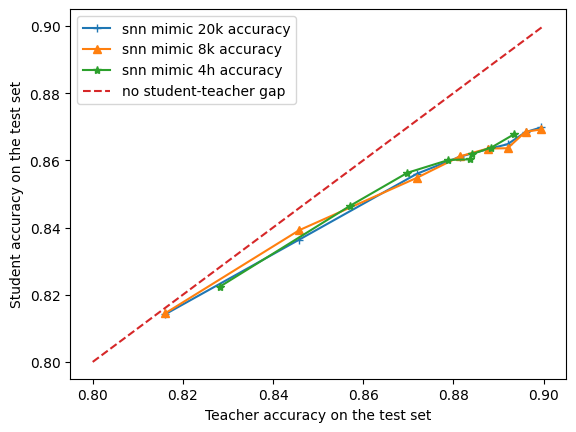

In [40]:
# Plot the student accuracy and teacher accuracy
plt.plot(results2['t_cnn_accuracy'], results2['snn_mimic_20k_accuracy'] , marker = '+', label='snn mimic 20k accuracy')
plt.plot(results2['t_cnn_accuracy'], results2['snn_mimic_8k_accuracy'], marker = '^', label='snn mimic 8k accuracy')
plt.plot(results2['t_cnn_accuracy'], results2['snn_mimic_4h_accuracy'], marker = '*', label='snn mimic 4h accuracy')

# add no student-teacher gap line y=x
plt.plot([0.8, 0.9], [0.8, 0.9], label='no student-teacher gap', linestyle='--')
plt.xlabel('Teacher accuracy on the test set')
plt.ylabel('Student accuracy on the test set')
plt.legend()
# save the figure
plt.savefig('student_teacher.png')

# save the results in a csv file
df = pd.DataFrame(results2)
df.to_csv('results2.csv', index=False)